In [2]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [3]:
import json
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray

import seaborn as sns

sns.set_theme()

In [4]:
with open("/home/yutanagano/Projects/tcr_embedder/benchmarks/Beta_CDR3_Levenshtein/metric_calibration/results.json", "r") as f:
    cdr3_levenshtein_data = json.load(f)
with open("/home/yutanagano/Projects/tcr_embedder/benchmarks/Beta_CDR_Levenshtein/metric_calibration/results.json", "r") as f:
    levenshtein_data = json.load(f)
with open("/home/yutanagano/Projects/tcr_embedder/benchmarks/Beta_tcrdist/metric_calibration/results.json", "r") as f:
    tcrdist_data = json.load(f)
with open("/home/yutanagano/Projects/tcr_embedder/benchmarks/Beta_CDR_BERT_Unsupervised/metric_calibration/results.json", "r") as f:
    bert_data = json.load(f)

In [5]:
data_dict = {
    "Levenshtein (CDR3 only)": cdr3_levenshtein_data,
    "Levenshtein": levenshtein_data,
    "tcrdist": tcrdist_data,
    "Unsupervised BLAsTR": bert_data
}

In [6]:
def get_enrichments(data: dict) -> ndarray:
    bg_dist_cdf_y = np.array(data["bg_dist_cdf"]["y_coords"])
    ep_dist_cdf_y = np.array(data["ep_matched_dist_cdf_minervina"]["y_coords"])
    return ep_dist_cdf_y / bg_dist_cdf_y

def get_recall(data: dict) -> ndarray:
    ep_dist_cdf_y = np.array(data["ep_matched_dist_cdf_minervina"]["y_coords"])
    return ep_dist_cdf_y

def get_deorphanisation_rate(data: dict) -> ndarray:
    deorphanisation_rate = np.array(data["deorphanisation_rate_minervina"]["y_coords"])
    return deorphanisation_rate

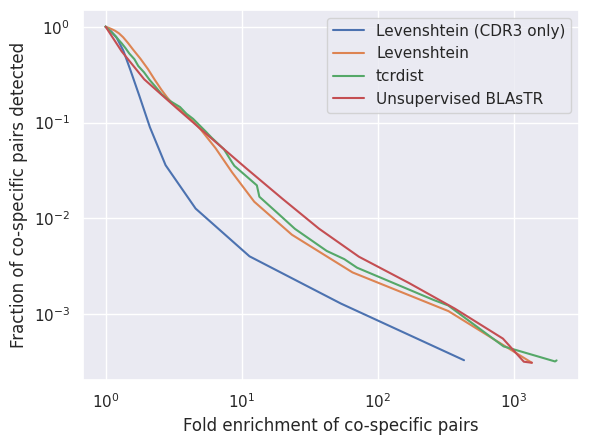

In [7]:
plt.figure()

for model_name, data in data_dict.items():
    recall = get_recall(data)
    enrichments = get_enrichments(data)
    indices_to_make_enrichments_monotonic = np.argsort(enrichments)

    plt.plot(enrichments[indices_to_make_enrichments_monotonic], recall[indices_to_make_enrichments_monotonic], label=model_name)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Fold enrichment of co-specific pairs")
plt.ylabel("Fraction of co-specific pairs detected")

plt.legend()

plt.show()

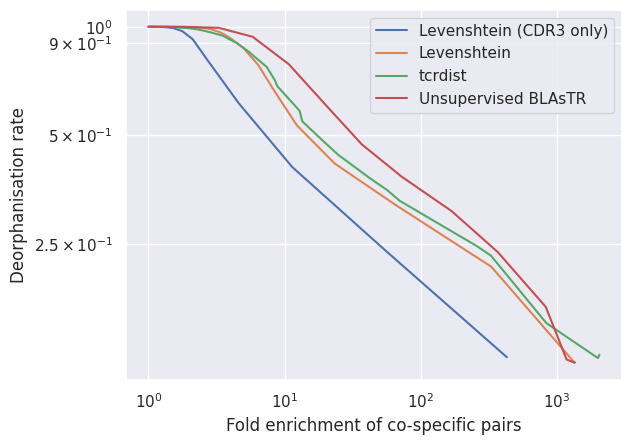

In [8]:
plt.figure()

for model_name, data in data_dict.items():
    deorphanisation_rate = get_deorphanisation_rate(data)
    enrichments = get_enrichments(data)
    indices_to_make_enrichments_monotonic = np.argsort(enrichments)

    plt.plot(enrichments[indices_to_make_enrichments_monotonic], deorphanisation_rate[indices_to_make_enrichments_monotonic], label=model_name)

plt.xscale("log")
plt.yscale("log")

plt.yticks([1.0, 0.9, 0.5, 0.25], ["$10^0$", r"$9 \times 10^{-1}$", r"$5 \times 10^{-1}$", r"$2.5 \times 10^{-1}$"])

plt.xlabel("Fold enrichment of co-specific pairs")
plt.ylabel("Deorphanisation rate")

plt.legend()

plt.show()